# Statistical Correlation Features

gwexpy makes it easy to calculate statistical correlations between TimeSeries objects. This is useful for noise hunting and investigating nonlinear coupling.

Supported methods:
- **Pearson (PCC)**: Linear correlation.
- **Kendall (Ktau)**: Rank correlation (robust to outliers, non-parametric).
- **MIC**: Maximal Information Coefficient (robust to nonlinear relationships, requires `minepy`).

In [1]:
import sys
import os
from pathlib import Path

# Ensure the root directory is in sys.path
root = Path.cwd()
while root.parent != root:
    if (root / "gwexpy").exists():
        if str(root) not in sys.path:
            sys.path.insert(0, str(root))
        break
    root = root.parent

import matplotlib.pyplot as plt
import numpy as np

from gwexpy.plot import PairPlot, Plot
from gwexpy.timeseries import TimeSeries, TimeSeriesMatrix

## Pairwise Correlation

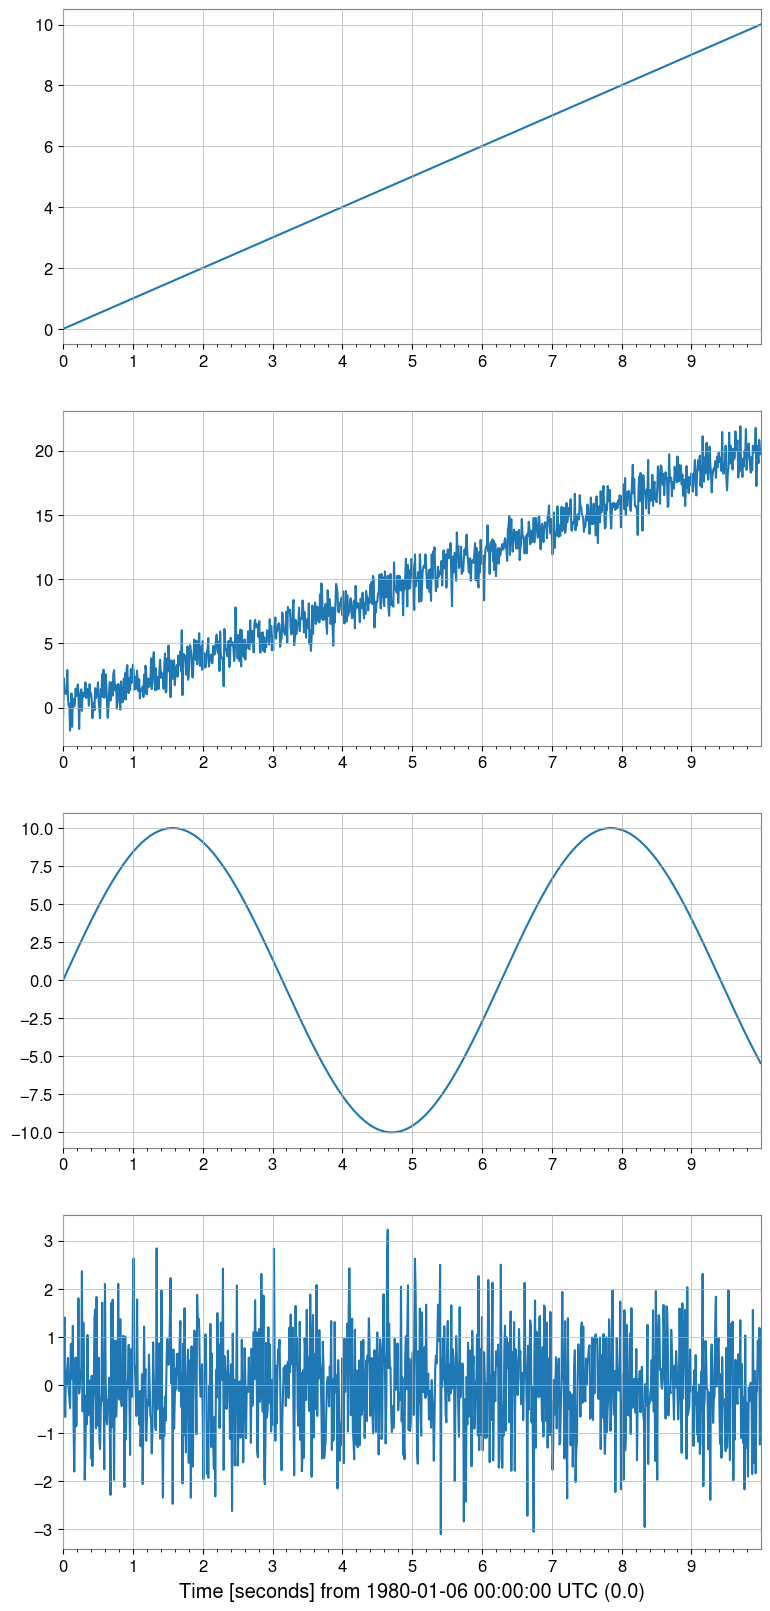

In [2]:
# Create dummy data
t = np.linspace(0, 10, 1000)

# Linear relationship
ts_a = TimeSeries(t, dt=0.01, name="A")
ts_b = TimeSeries(t * 2 + np.random.normal(0, 1, 1000), dt=0.01, name="B_Linear")

# Nonlinear relationship (sine wave)
ts_c = TimeSeries(np.sin(t) * 10, dt=0.01, name="C_Sine")

# Random noise
ts_d = TimeSeries(np.random.normal(0, 1, 1000), dt=0.01, name="D_Noise")

Plot(ts_a, ts_b, ts_c, ts_d, separate=True, sharex=True);

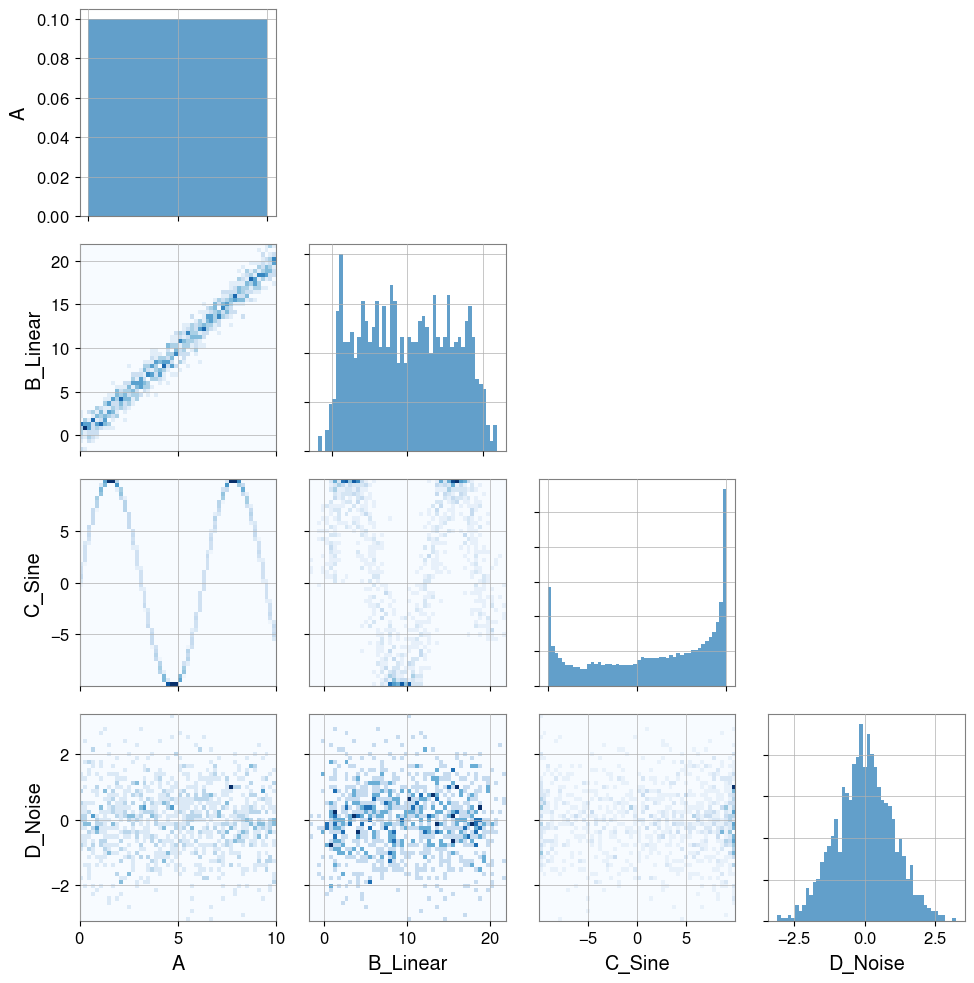

In [3]:
# Visualization
pair = PairPlot([ts_a, ts_b, ts_c, ts_d], corner=True)
pair.show()

In [4]:
print("Correlation A vs B (linear):")
print(f"  Pearson: {ts_a.pcc(ts_b):.3f}")
print(f"  Kendall: {ts_a.ktau(ts_b):.3f}")
try:
    print(f"  MIC:     {ts_a.mic(ts_b):.3f}")
except ImportError:
    from IPython.display import Markdown, display
    display(Markdown("""
    **Note**:   MIC:     (minepy not available)
    
    """))


Correlation A vs B (linear):
  Pearson: 0.985
  Kendall: 0.892
  MIC:     (minepy not available)


In [5]:
print("Correlation A vs C (nonlinear sine wave):")
print(f"  Pearson: {ts_a.pcc(ts_c):.3f} (linear correlation cannot capture structure)")
print(f"  Kendall: {ts_a.ktau(ts_c):.3f}")
try:
    print(f"  MIC:     {ts_a.mic(ts_c):.3f} (captures nonlinear dependency)")
except ImportError:
    from IPython.display import Markdown, display
    display(Markdown("""
    **Note**:   MIC:     (minepy not available)
    
    """))


Correlation A vs C (nonlinear sine wave):
  Pearson: -0.071 (linear correlation cannot capture structure)
  Kendall: -0.053
  MIC:     (minepy not available)


## Correlation Vector (Noise Hunting)

When investigating noise sources, we often want to check correlations between a target channel (e.g., DARM) and hundreds of auxiliary channels.
`TimeSeriesMatrix.correlation_vector` efficiently computes this ranking.

In [6]:
# Create a Matrix with many auxiliary channels
n_channels = 20
data = np.random.randn(n_channels, 1, 1000)
names = [f"AUX-{i:02d}" for i in range(n_channels)]

# Inject signals into AUX-05 and AUX-12
target_signal = np.sin(np.linspace(0, 20, 1000))
data[5, 0, :] += target_signal * 5  # Strong coupling
data[12, 0, :] += target_signal**2 * 5  # Nonlinear coupling

matrix = TimeSeriesMatrix(data, dt=0.01, channel_names=names)

# Target channel
target = TimeSeries(
    target_signal + np.random.normal(0, 0.1, 1000), dt=0.01, name="TARGET"
)

In [7]:
# Compute correlation vector
# Use 'mic' to capture both linear and nonlinear (slower but powerful)
# Use 'pearson' for speed

try:
    print("Computing MIC vector (Top 5)...")
    df_mic = matrix.correlation_vector(target, method="mic", nproc=2)
    print(df_mic.head(5))
except ImportError:
    from IPython.display import Markdown, display
    display(Markdown("""
    **Note**: Skipping MIC example because minepy is not installed.
    
    """))


Computing MIC vector (Top 5)...
   row  col channel  score
0    0    0  AUX-00    NaN
1    1    0  AUX-01    NaN
2    2    0  AUX-02    NaN
3    3    0  AUX-03    NaN
4    4    0  AUX-04    NaN


In [8]:
print("Computing Pearson vector (Top 5)...")
df_pcc = matrix.correlation_vector(target, method="pearson", nproc=1)
print(df_pcc.head(5))

Computing Pearson vector (Top 5)...
   row  col channel     score
0    5    0  AUX-05  0.953862
1   10    0  AUX-10 -0.067360
2    0    0  AUX-00 -0.058662
3    2    0  AUX-02 -0.056880
4   13    0  AUX-13 -0.054595


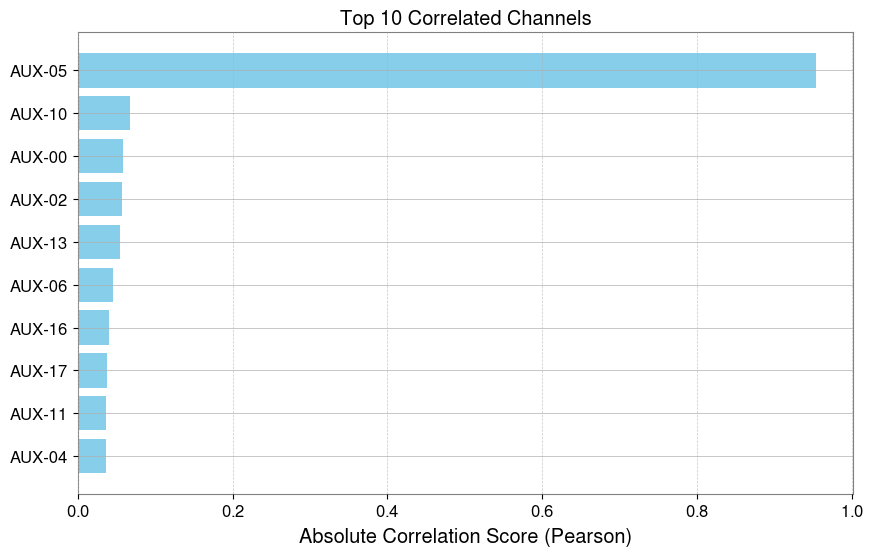

In [9]:
# Visualize ranking (Top 10)
df_plot = df_pcc.head(10).iloc[::-1]  # Reverse to descending order

plt.figure(figsize=(10, 6))
plt.barh(df_plot["channel"], np.abs(df_plot["score"]), color="skyblue")
plt.xlabel("Absolute Correlation Score (Pearson)")
plt.title("Top 10 Correlated Channels")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

## Partial Correlation (Confound Control)

Partial correlation estimates direct coupling by removing shared confounds.


In [10]:
import numpy as np
from gwexpy.timeseries import TimeSeries

rng = np.random.default_rng(0)
t = np.linspace(0, 10, 1000)
z = np.sin(2 * np.pi * 0.5 * t) + 0.1 * rng.standard_normal(t.size)
x = z + 0.1 * rng.standard_normal(t.size)
y = z + 0.1 * rng.standard_normal(t.size)

ts_x = TimeSeries(x, dt=t[1] - t[0], name="x")
ts_y = TimeSeries(y, dt=t[1] - t[0], name="y")
ts_z = TimeSeries(z, dt=t[1] - t[0], name="z")

print("corr(x,y):", ts_x.correlation(ts_y, method="pearson"))
print("partial corr(x,y|z):", ts_x.partial_correlation(ts_y, controls=ts_z, method="residual"))


## Association Edges and Graphs

Use a target TimeSeries against a TimeSeriesMatrix to build edges.


In [11]:
from gwexpy.timeseries import TimeSeriesMatrix
from gwexpy.analysis import association_edges, build_graph

matrix = TimeSeriesMatrix(
    np.stack([x, y, z], axis=0)[:, None, :],
    dt=t[1] - t[0],
    channel_names=["x", "y", "z"],
)

edges = association_edges(ts_x, matrix, method="pearson", topk=3)
print("Association edges:\n", edges)

pcorr = matrix.partial_correlation_matrix(shrinkage="auto")
print("Partial correlation matrix:\n", pcorr)

# If networkx is available:
graph = build_graph(edges, backend="none")
print("Graph built successfully.")

### Visualization: Edge Ranking and Partial-Corr Heatmap


In [ ]:
import matplotlib.pyplot as plt

# Bar plot of top edges
top = edges.sort_values('score', ascending=False, key=abs).head(10)
plt.figure(figsize=(6, 3))
plt.barh(top['target'], top['score'])
plt.gca().invert_yaxis()
plt.xlabel('score')
plt.title('Top associations')
plt.show()

# Heatmap of partial correlation
plt.figure(figsize=(4, 3))
plt.imshow(pcorr, vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar(label='partial corr')
plt.title('Partial correlation matrix')
plt.show()


## FastMI (Experimental)

FastMI is a fast mutual-information (MI) estimator based on a copula formulation (empirical CDF), a probit transform, and an FFT-based self-consistent density estimate.

- API: `TimeSeries.fastmi(other, grid_size=..., quantile=..., eps=...)` or `correlation(other, method="fastmi")`
- Output: MI in **nats** (>= 0). Larger means stronger dependence (linear or nonlinear).
- Parameters:
  - `grid_size`: FFT grid resolution (trade-off: accuracy vs speed).
  - `quantile`: trims extreme probit tails for numerical stability.
  - `eps`: floor for probabilities/densities to avoid `log(0)`.


In [ ]:
# fastMI (copula/probit + FFT-based MI estimator)
# NOTE: this can be slower than Pearson for small n, but is useful for nonlinear dependence.
print('fastMI(x,y):', ts_x.fastmi(ts_y, grid_size=128))
print('fastMI(x,z):', ts_x.fastmi(ts_z, grid_size=128))


## CAGMon-style Association Graph (Minimal)

Use the edge list and optionally build a graph for visualization.


In [ ]:
# If networkx is available, you can visualize the association graph
try:
    import networkx as nx
    G = build_graph(edges, backend='networkx')
    plt.figure(figsize=(4, 3))
    pos = nx.spring_layout(G, seed=0)
    nx.draw(G, pos, with_labels=True, node_size=500, font_size=8)
    plt.title('Association Graph')
    plt.show()
except Exception as e:
    print('Graph plot skipped:', e)


# Advanced Statistics

gwexpy provides advanced statistical capabilities not only for correlation but also for examining data distribution shape and causality.

- **Skewness**: Asymmetry of the distribution.
- **Kurtosis**: Heaviness of distribution tails (presence of outliers).
- **Distance Correlation (dCor)**: Measure of nonlinear dependency.
- **Granger Causality**: Causality between time series (contribution to prediction).

## Detecting Non-Gaussian Noise (Skewness / Kurtosis)

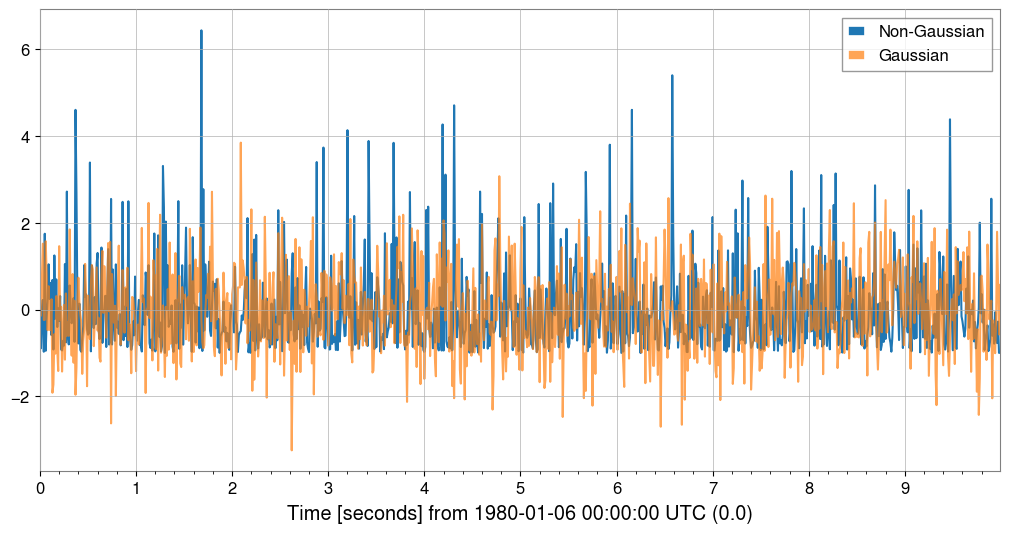

Gaussian:     Skewness=0.117, Kurtosis=0.066
Non-Gaussian: Skewness=1.981, Kurtosis=5.379
Note: Gaussian distributions have Skewness~0, Kurtosis~0 (Fisher definition).


In [12]:
# Generate Gaussian noise and non-Gaussian noise (exponential distribution)
np.random.seed(42)
gauss_noise = TimeSeries(np.random.normal(0, 1, 1000), dt=0.01, name="Gaussian")
exp_noise = TimeSeries(
    np.random.exponential(1, 1000) - 1, dt=0.01, name="Non-Gaussian"
)  # Centered

# Plot
plot = exp_noise.plot(label="Non-Gaussian")
plot.gca().plot(gauss_noise, label="Gaussian", alpha=0.7)
plot.gca().legend()
plot.show()

# Calculate statistics
print(
    f"Gaussian:     Skewness={gauss_noise.skewness():.3f}, Kurtosis={gauss_noise.kurtosis():.3f}"
)
print(
    f"Non-Gaussian: Skewness={exp_noise.skewness():.3f}, Kurtosis={exp_noise.kurtosis():.3f}"
)
print("Note: Gaussian distributions have Skewness~0, Kurtosis~0 (Fisher definition).")

## Detecting Nonlinear Dependency (Distance Correlation)

Let's examine the relationship between the sine wave data (`ts_c`) and linear data (`ts_a`) using dCor. We can detect relationships that Pearson correlation cannot capture.

In [13]:
try:
    dcor_val = ts_a.distance_correlation(ts_c)
    print(f"Distance Correlation (A vs C): {dcor_val:.3f}")
    print(f"Pearson Correlation  (A vs C): {ts_a.pcc(ts_c):.3f}")
except ImportError:
    from IPython.display import Markdown, display
    display(Markdown("""
    **Note**: dcor package is not installed. Install it with: pip install dcor
    
    """))


Distance Correlation (A vs C): 0.381
Pearson Correlation  (A vs C): -0.071


## Estimating Causality (Granger Causality)

Tests whether past values of one time series help predict future values of another time series.

In [14]:
# Generate data with causal relationship (X -> Y)
np.random.seed(0)
n = 200
x_val = np.random.randn(n)
y_val = np.zeros(n)

# Y depends on the value of X one step before
for i in range(1, n):
    y_val[i] = 0.5 * y_val[i - 1] + 0.8 * x_val[i - 1] + 0.1 * np.random.randn()

ts_x = TimeSeries(x_val, dt=1, name="Cause (X)")
ts_y = TimeSeries(y_val, dt=1, name="Effect (Y)")

try:
    # Does X cause Y? (Does X help predict Y?) -> p-value should be small
    p_xy = ts_y.granger_causality(ts_x, maxlag=5)
    # Does Y cause X? -> p-value should be large
    p_yx = ts_x.granger_causality(ts_y, maxlag=5)
    print(
        f"Granger Causality X -> Y (p-value): {p_xy:.4f} {'(Significant)' if p_xy < 0.05 else ''}"
    )
    print(
        f"Granger Causality Y -> X (p-value): {p_yx:.4f} {'(Significant)' if p_yx < 0.05 else ''}"
    )
except ImportError:
    from IPython.display import Markdown, display
    display(Markdown("""
    **Note**: The statsmodels package is not installed. To perform Granger causality analysis:
    ```bash
    pip install statsmodels
    ```
    You can continue with the rest of the notebook.
    """))

Granger Causality X -> Y (p-value): 0.0000 (Significant)
Granger Causality Y -> X (p-value): 0.0907 


<python-env>/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


## Fast Mutual Information (fastmi)

`fastmi` is a fast mutual-information (MI) estimator based on a copula formulation, a probit transform, and an FFT-based density estimate. It captures complex nonlinear dependencies that Pearson correlation might miss.

In [ ]:
mi_xy = ts_x.fastmi(ts_y, grid_size=128)
mi_xz = ts_x.fastmi(ts_z, grid_size=128)

print(f"Mutual Information (x, y): {mi_xy:.4f} nats")
print(f"Mutual Information (x, z): {mi_xz:.4f} nats")